### FRB Event Rate

Calculate the expected FRB event rate for thew ALFABURST survey based on Lorimer et al. 2013

**Assumptions**

1. Pulse width is approximately 1 ms
2. FRB is a standard candles
3. Thornton et al. 2013 correctly relates flux density to redshift

From Champion et al. 2016:

a rate of $7^{+5}_{−3} \times 10^3$ (95 per cent confidence interval) FRBs $\textrm{sky}^{−1} \textrm{d}^{−1}$ above a fluence of 0.13 Jy ms for an FRB of 0.128 ms duration to 1.5 Jy ms for 16 ms duration. ... This is consistent with those previously reported in Thornton et al. (2013), Spitler et al. (2014), and Rane et al. (2016) within the quoted uncertainties. It should be noted that this rate is specific to the observing setup described in this Letter as this setup is not fluence-complete to the same level as other surveys, thus it is only directly comparable to Thornton et al. (2013).

Fluence in units [Jy ms] and is defined as:

$$F_{obs} = S_{peak, obs} \cdot W_{obs}$$

Catalogue of published FRBs: https://www.astronomy.swin.edu.au/pulsar/frbcat/

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate
from matplotlib import rc
import pandas as pd

%matplotlib inline
rc('text', usetex=True)
plt.rcParams['figure.figsize'] = (8, 6)

Equation 6 of Karastergiou et al. 2015 is derived from the radiometer equation:

$$
S_{min} = \textrm{SEFD} \frac{\textrm{SNR}_{min}}{\sqrt{D \; \Delta \tau \; \Delta \nu}}
$$

where $S_{min}$ is the minimum flux density (in Jy) detection rate. This is based on the telescope SEFD, the minimum SNR detection level $\textrm{SNR}_{min}$ and the decimation rate $D$ compared to the native instrumental time resolution $\tau$, this comes from the search pipeline which averages together spectra to search for scattered pulses. ALFABURST has a native resolution of $\Delta \tau = 256 \; \mu s$, effective bandwidth $\Delta \nu = 56 \textrm{MHz}$, and $\textrm{SNR}_{min} = 10$.

For reference see:
* https://www.cv.nrao.edu/course/astr534/Radiometers.html
* http://www.naic.edu/alfa/performance/
* https://casper.berkeley.edu/astrobaki/index.php/Radiometer_Equation_Applied_to_Telescopes
* https://science.nrao.edu/facilities/vla/docs/manuals/oss/performance/sensitivity

In [28]:
# Parameters
SEFD = 3. # Jy, SEFD of ALFA (main beam)
threshold = 10. # SNR threshold of detection pipeline
pulseWidth = np.array([1., 2., 4., 8., 16., 32., 64.]) * 1000. # us, expected pulse width
tRes = 256. # us, ALFABURST spectra time resolution
dFactor = pulseWidth / tRes# decimation factor
bw = 56. * 1e6 # ALFABURST effective bandwidth in Hz
sMin = SEFD * (threshold / np.sqrt(dFactor * (tRes * 1e-6) * bw)) # Minimum flux density detection, based on radiometer equation

fObsMin = 1347e6 # ALFABURST 56 MHz bandwidth system min frequency
fObsMax = 1403e6 # ALFABURST 56 MHz bandwidth system max frequency

alphas = [-2., -1.4, -0.7, -0.1, 0.1, 0.7] # spectral indicies to model
zMin = 0.01
#zMax = 4.0
#zMax = 7.997 # minimum z based on pointing and NE2001 from frb_search_volume.ipynb
zMax = 2.5

In [29]:
print 'The minimum flux density detection for a given pulse width is:'
for sMinVal, pwVal in zip(sMin, pulseWidth):
    print '\t %.1f mJy for a pulse width of %.0f ms'%(sMinVal*1000., pwVal/1000.)

The minimum flux density detection for a given pulse width is:
	 126.8 mJy for a pulse width of 1 ms
	 89.6 mJy for a pulse width of 2 ms
	 63.4 mJy for a pulse width of 4 ms
	 44.8 mJy for a pulse width of 8 ms
	 31.7 mJy for a pulse width of 16 ms
	 22.4 mJy for a pulse width of 32 ms
	 15.8 mJy for a pulse width of 64 ms


In [31]:
def coMovingDist(z):
    """Co-moving distance in Gpc, Eq. 3 from Lorimer et al. 2013
    z: float, redshift
    """
    c = 299792.458 # km s^-1
    H0 = 68. # km s^-1 Mpc^-1
    OmegaM = 0.32
    OmegaLambda = 0.68
    
    integrand = lambda zp: 1. / np.sqrt(OmegaM * ((1. + zp)**3.) + OmegaLambda)
    dd, err = scipy.integrate.quad(integrand, 0., z)
    return ((c/H0) * dd) * 1e-3

def coMovingVol(z):
    """Co-moving volume in Gpc^3
    z: float, redshift"""
    return (4./3.)*(coMovingDist(z)**3.)

def calcLModel(sPeakRef=1., alphaRef=-1.4, zRef=0.75, fLumMin=1e7, fLumMax=1e10, fObsMin=1182e6, fObsMax=1582e6):
    """Calculate the standard candle FRB bolometric luminosity based on Thornton et al. 2013 model, this is used
    to calibrate the flux-redshift relationship
    sPeakRef: float, Jy, peak flux density, Thornton et al.: 1.
    alphaRef: float, spectal index, Thornton et al.: -1.4
    zRef: float, redshift, Thornton et al.: 0.75
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    fObsMin: float, Hz, minimum observing frequency, Thornton et al.: 1186 MHz
    fObsMax: float, Hz, maximum observing frequency, Thornton et al.: 1582 MHz"""
    sPeakRefErgs = sPeakRef * 1e-19 # unit: erg s^-1 ; 1 Jy = 10^-26 W = 10^-19 erg s^-1
    
    dd = coMovingDist(zRef) * 3.086e25 # Convert from Gpc to m

    LL = ((fObsMax-fObsMin)/((fObsMax**(alphaRef+1.))-(fObsMin**(alphaRef+1.)))) * sPeakRefErgs \
            * 4. * np.pi * (dd**2.) \
            * (((fLumMax**(alphaRef+1.))-(fLumMin**(alphaRef+1.)))/((1.+zRef)**(alphaRef-1.)))
    return LL

def calcSpeak(LModel, z, alpha, fObsMin, fObsMax, fLumMin=1e7, fLumMax=1e10):
    """Calculate the peak flux density, Lorimer et al. 2013 eq. 9
    LModel: float, ergs s^-1, bolometric luminosity model output of calcLModel()
    z: float, redshift of source
    alpha: float, spectral index of FRB standard candle model
    fObsMin: float, Hz, minimum observing frequency
    fObsMax: float, Hz, maximum observing frequency
    fLumMin: float, Hz, minimum frequency over which the source emits, Lorimer et al.: 1e7
    fLumMax: float, Hz, maximum frequency over which the source emits, Lorimer et al.: 1e10
    """
    dd = coMovingDist(z) * 3.086e25 # Convert from Gpc to m
    
    sPeak = (LModel * ((1. + z)**(alpha-1.))) \
            * (1. / (4. * np.pi * dd**2. * ((fLumMax**(alpha+1.)) - (fLumMin**(alpha+1.)))) ) \
            * (((fObsMax**(alpha+1.)) - (fObsMin**(alpha+1.)))/(fObsMax - fObsMin))

    return sPeak / 1e-19

In [30]:
# From FRBCAT
df = pd.DataFrame(index=['Flux', 'W', 'DM', 'z'])
df['FRB010125'] = [0.30, 9.4, 790., 0.57]
df['FRB010621'] = [0.53, 8., 748., 0.19]
df['FRB010724'] = [1.57, 20., 375., 0.28]
df['FRB090625'] = [1.14, 1.92, 899.55, 0.72]
df['FRB110220'] = [1.3, 5.6, 944.38, 0.76]
df['FRB110523'] = [0.6, 1.73, 623.3, 0.48]
df['FRB110626'] = [0.56, 1.4, 723., 0.56]
df['FRB110703'] = [0.5, 4.3, 1103.6, 0.89]
df['FRB120127'] = [0.55, 1.1, 553.3, 0.43]
df['FRB121002'] = [0.43, 5.44, 1629.18, 1.3]
df['FRB121102'] = [0.4, 3., 557., 0.31]
df['FRB130626'] = [0.74, 1.98, 952.4, 0.74]
df['FRB130628'] = [1.91, 0.64, 469.88, 0.35]
df['FRB131104'] = [1.12, 2.08, 779., 0.59]
df['FRB130729'] = [0.22, 15.61, 861., 0.69]
df['FRB140514'] = [0.47, 2.8, 562.7, 0.44]
df['FRB150418'] = [2.20, 0.8, 776.2, 0.49]
df['FRB150807'] = [128., 0.35, 266.5, 0.16]

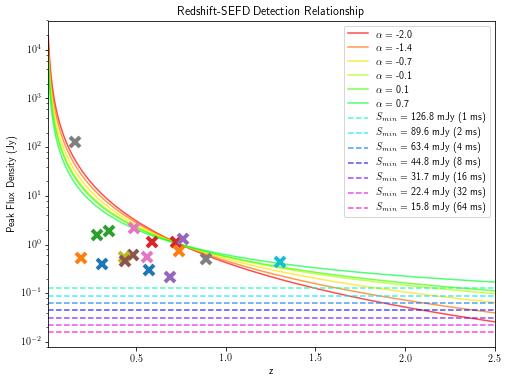

In [47]:
zArr = np.linspace(zMin, zMax, 1024)
sPeakArr = np.zeros((len(alphas), len(zArr)))

cmap = plt.cm.hsv
colors = iter(cmap(np.linspace(0, 0.9, len(alphas) + len(sMin))))

for aid, alpha in enumerate(alphas):
    LModel = calcLModel(alphaRef=alpha)
    for zid,zz in enumerate(zArr):
        sPeakArr[aid, zid] = calcSpeak(LModel, zz, alpha, fObsMin, fObsMax)
    plt.semilogy(zArr, sPeakArr[aid], color=next(colors), alpha=0.7, label=r'$\alpha =$ %1.1f'%alpha)

idxArr = np.zeros((len(sMin),len(alphas)), dtype='int')
#for sMinVal, pwVal in zip(sMin, pulseWidth):
for smid, sMinVal in enumerate(sMin):
    pwVal = pulseWidth[smid]
    plt.axhline(y=sMinVal, xmin=0.0, xmax=1.0, color=next(colors), linestyle="--", alpha=0.7, \
                label='$S_{min}=$ %1.1f mJy (%.0f ms)'%(sMinVal*1000., pwVal/1000.))
    for aid, alpha in enumerate(alphas):
        idx = np.argmin(np.abs(sPeakArr[aid] - sMinVal)) # array index of nearest sMin/alpha flux density crossing
        #print alpha, sMinVal, idx, zArr[idx]
        idxArr[smid, aid] = idx

for idx, row in df.iteritems():
    #print idx, row
    plt.plot(row['z'], row['Flux'], "x", markersize=10, markeredgewidth=4)
        
plt.legend()
plt.xlim(zMin, zMax)
plt.xlabel('z')
plt.ylabel('Peak Flux Density (Jy)')
plt.title('Redshift-SEFD Detection Relationship')
#plt.savefig('redshift-sefd.svg')

**Figure:** Similar to Figure 6 of Karastergiou et al. 2015, and Figure 2a of Lorimer et al. 2013. Peak flux density of the Lorimer et al. 2013 population model as a function of redshift $z$ and spectral index $\alpha$. Lines of minimum dectection using the ALFABURST system is shown as dashed lines for different decimation levels. Markers are previously discovered FRBs from FRBCAT catalogue.

In [33]:
# lorimer 2b, karastergious 6 - rate to redshift relationship
def thorntonRate(z):
    """Compute the event rate using Thornton et al. 2013 values as computed by Lormier et al. 2013
    z: float, redshift
    returns: array, [low rate, expected rate, high rate]"""
    dd = coMovingDist(z)
    dNorm = coMovingDist(0.75) # Thornton rate is based on events at z=0.75
    rateNorm = np.array([0.5 * 10**4, 10**4, 1.6 * 10**4]) # Thornton et al. 2013: rate = 10000 (error: +6000/-5000)
    rate = rateNorm * ((dd / dNorm)**3.)
    return rate

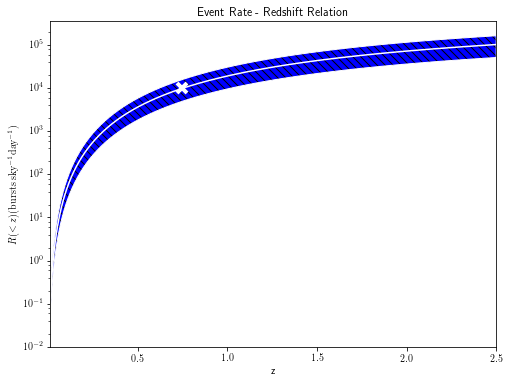

In [34]:
expectedRates = np.zeros((zArr.shape[0], 3))
for zid,zz in enumerate(zArr):
    expectedRates[zid,:] = thorntonRate(zz)

plt.semilogy(zArr, expectedRates[:,1], "w")
plt.fill_between(zArr, expectedRates[:,0], expectedRates[:,2], alpha=1.0, facecolor="blue", edgecolor="white", \
                 hatch="\\\\\\")

plt.plot(0.75, 1e4, "wx", markersize=10, markeredgewidth=4) # plot Thornton et al. (2013) rate

plt.xlim(zMin, zMax)
plt.xlabel('z')
plt.ylabel(r'$R (< z) (\textrm{bursts sky}^{-1} \textrm{day}^{-1})$')

plt.title('Event Rate - Redshift Relation')

**Figure:** Implied redshift to event rate relation based on Thornton et al. 2013 event rate of $10000^{+6000}_{-5000} \; \textrm{bursts sky}^{-1} \textrm{day}^{-1}$ at $z = 0.75$ (white cross).

In [35]:
# Determine expected number of detections based on rate per sky, time for current sky,time coverage

# 4 * pi steradian in a sphere
sqDegPerSky = 4. * np.pi * ((180. / np.pi)**2.)

# From frb_search_volume.ipynb:
# Observing time outside the galactic plane (+/-7.0 degrees) = 2175300 s
# Total area surveyed = 4.748e+03 sq. deg
obsTimeSec = 2175300. # seconds
obsTimeDay = obsTimeSec / (24. * 60. * 60.) # days
nBeams = 7. # number of beams, for ALFA this is 7
beamFWHM = nBeams * (3.5 / 60.) # beam FWHM in degrees
areaDeg = np.pi * (beamFWHM/2.)**2. # beam area in deg^2
areaInSky = areaDeg / sqDegPerSky # the beam size as a precent of the total sky

# Event rate based on maximum redshift which can be probed by the sensitivity of ALFABURST
for smid, sMinVal in enumerate(sMin):
    print 'pulse width: %.0f ms (minimum flux density: %.1f mJy)'%(pulseWidth[smid]/1000., sMinVal*1000.)
    for aid, alpha in enumerate(alphas):
        idx = idxArr[smid, aid]
        print '\t alpha: %.1f \t max z: %.1f \t rate: %.0f (+%.0f / -%0.f) FRBs sky^-1 day^-1'%  \
        (alpha, zArr[idx], expectedRates[idx, 1], expectedRates[idx, 2] - expectedRates[idx, 1], \
         expectedRates[idx, 1] - expectedRates[idx, 0])
        print '\t ALFABURST Expected FRB count: %i'%(int(expectedRates[idx, 1] * areaInSky * obsTimeDay))

pulse width: 1 ms (minimum flux density: 126.8 mJy)
	 alpha: -2.0 	 max z: 1.5 	 rate: 43866 (+26320 / -21933) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 3
	 alpha: -1.4 	 max z: 1.6 	 rate: 51111 (+30667 / -25556) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 4
	 alpha: -0.7 	 max z: 1.8 	 rate: 64040 (+38424 / -32020) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 5
	 alpha: -0.1 	 max z: 2.2 	 rate: 83308 (+49985 / -41654) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 6
	 alpha: 0.1 	 max z: 2.3 	 rate: 93004 (+55802 / -46502) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 7
	 alpha: 0.7 	 max z: 2.5 	 rate: 103768 (+62261 / -51884) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 8
pulse width: 2 ms (minimum flux density: 89.6 mJy)
	 alpha: -2.0 	 max z: 1.7 	 rate: 54047 (+32428 / -27023) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 4
	 alpha: -1.4 	 max z: 1.8 	 rate: 64040 (+38424 / -32020) FRBs sky^-1 day^-1
	 ALFABURST Expected FRB count: 5
	 